# Matomo Web Analytics: User Behavior Analysis and Clustering

This notebook provides a comprehensive analysis of Matomo web analytics data to understand:
1. User behavior patterns
2. Bot detection
3. Visit patterns and user journeys
4. User segmentation using clustering
5. Time-based patterns and trends

We'll analyze the data from multiple angles to provide actionable insights about website visitors.

In [2]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.1 MB/s eta 0:00:00a 0:00:01


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from datetime import datetime
import pytz
import pycountry
import warnings
warnings.filterwarnings('ignore')


## 1. Data Loading and Preprocessing

We'll load the three main Matomo tables:
- log_visit: Contains information about each visit
- log_link_visit_action: Contains information about each action within a visit
- log_action: Contains details about the actions (URLs, page titles, etc.)

In [10]:
# Load the datasets
log_visit = pd.read_csv('exported_tables/matomo_log_visit.csv', on_bad_lines='skip', index_col=False)
log_link_visit = pd.read_csv('exported_tables/matomo_log_link_visit_action.csv', index_col=False)
log_action = pd.read_csv('exported_tables/matomo_log_action.csv', index_col=False)

# Display basic information about the datasets
print("Dataset shapes:")
print(f"log_visit: {log_visit.shape}")
print(f"log_link_visit: {log_link_visit.shape}")
print(f"log_action: {log_action.shape}")

Dataset shapes:
log_visit: (1000, 60)
log_link_visit: (1000, 41)
log_action: (1000, 5)


In [12]:
log_action.head()

,idaction,name,hash,type,url_prefix
0,1,Vipani | Smart Procurement Platform for the Di...,1313366454,4,NaN
1,2,localhost/rfq/buyer/generate-po?quoteId=1127&r...,3909166454,1,0.0
2,3,localhost/rfq/sellers/rfq-list,2509562998,1,0.0
3,4,localhost/order-management,3743773319,1,0.0
4,5,192.168.9.133/,876754619,1,0.0


In [13]:
log_link_visit.head()

,idlink_va,idsite,idvisitor,idvisit,idaction_url_ref,idaction_name_ref,custom_float,pageview_position,server_time,idpageview,...,time_network,time_on_load,time_server,time_transfer,time_spent,custom_dimension_1,custom_dimension_2,custom_dimension_3,custom_dimension_4,custom_dimension_5
0,1,1,<memory at 0x74a5a9a831c0>,1,0,0,NaN,1,2025-02-21 09:50:35,edNZua,...,326.0,NaN,575.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,<memory at 0x74a5a9a83040>,1,2,1,NaN,2,2025-02-21 09:50:35,L3xMsC,...,305.0,NaN,558.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,<memory at 0x74a5a9a83280>,1,3,1,NaN,3,2025-02-21 09:50:36,Yb1iEF,...,261.0,NaN,575.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,<memory at 0x74a5a9a83340>,1,4,1,NaN,4,2025-02-21 09:50:40,g6VqCv,...,0.0,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,<memory at 0x74a5a9a83400>,1,2,1,NaN,5,2025-02-21 09:51:55,6I94Oo,...,315.0,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
log_visit.head()

,idvisit,idsite,idvisitor,visit_last_action_time,config_id,location_ip,profilable,user_id,visit_first_action_time,visit_goal_buyer,...,location_country,location_latitude,location_longitude,location_region,last_idlink_va,custom_dimension_1,custom_dimension_2,custom_dimension_3,custom_dimension_4,custom_dimension_5
0,1,1,<memory at 0x74a5a9a82ec0>,2025-02-21 10:04:38,<memory at 0x74a5a9a82f80>,<memory at 0x74a5a9a82e00>,1,NaN,2025-02-21 09:50:35,0,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,<memory at 0x74a5a9a82d40>,2025-02-21 11:09:04,<memory at 0x74a5a9a82c80>,<memory at 0x74a5a964eec0>,1,NaN,2025-02-21 11:09:04,0,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,<memory at 0x74a5a964ed40>,2025-02-21 11:48:56,<memory at 0x74a5a964ee00>,<memory at 0x74a5a964ef80>,1,NaN,2025-02-21 11:38:50,0,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,<memory at 0x74a5a964f040>,2025-02-21 11:56:21,<memory at 0x74a5a964f100>,<memory at 0x74a5a964f1c0>,1,NaN,2025-02-21 11:56:14,0,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,<memory at 0x74a5a964f280>,2025-02-21 11:59:28,<memory at 0x74a5a964f340>,<memory at 0x74a5a964f400>,1,NaN,2025-02-21 11:59:28,0,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Merge tables to create complete user journey data
def create_complete_journey_data(log_visit_df, log_link_visit_df, log_action_df):
    # First merge link_visit with action to get page names
    journey_data = pd.merge(
        log_link_visit_df,
        log_action_df[['idaction', 'name', 'type', 'url_prefix']],
        left_on='idaction_url',
        right_on='idaction',
        how='left',
        suffixes=('', '_page')
    )
    
    # Merge with visit data to get visit context
    journey_data = pd.merge(
        journey_data,
        log_visit_df,
        on='idvisit',
        how='left'
    )
    
    return journey_data

# Create complete journey dataset
complete_journey_data = create_complete_journey_data(log_visit, log_link_visit, log_action)

print("Complete journey data shape:", complete_journey_data.shape)
print("\nSample columns:", complete_journey_data.columns.tolist()[:10])

Complete journey data shape: (1000, 104)

Sample columns: ['idlink_va', 'idsite_x', 'idvisitor_x', 'idvisit', 'idaction_url_ref', 'idaction_name_ref', 'custom_float', 'pageview_position', 'server_time', 'idpageview']


In [15]:
complete_journey_data.head()

,idlink_va,idsite_x,idvisitor_x,idvisit,idaction_url_ref,idaction_name_ref,custom_float,pageview_position,server_time,idpageview,...,location_country,location_latitude,location_longitude,location_region,last_idlink_va,custom_dimension_1_y,custom_dimension_2_y,custom_dimension_3_y,custom_dimension_4_y,custom_dimension_5_y
0,1,1,<memory at 0x74a5a9a831c0>,1,0,0,NaN,1,2025-02-21 09:50:35,edNZua,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,<memory at 0x74a5a9a83040>,1,2,1,NaN,2,2025-02-21 09:50:35,L3xMsC,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,<memory at 0x74a5a9a83280>,1,3,1,NaN,3,2025-02-21 09:50:36,Yb1iEF,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,<memory at 0x74a5a9a83340>,1,4,1,NaN,4,2025-02-21 09:50:40,g6VqCv,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,<memory at 0x74a5a9a83400>,1,2,1,NaN,5,2025-02-21 09:51:55,6I94Oo,...,in,19.076,72.878,MH,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning and Feature Engineering

Let's clean the data and create useful features for our analysis:
1. Remove unnecessary columns
2. Handle missing values
3. Create derived features for better insights
4. Join relevant tables

In [16]:
# Create URL mapping in log_action
url_prefix_map = {
    0.0: 'http://',  # No prefix
    1.0: 'http://www.',
    2.0: 'https://',
    3.0: 'https://www.'
}

def build_action_url(row):
    if row['type'] in [1, 2, 3]:  # Include type 0
        prefix = url_prefix_map.get(row['url_prefix'], '')
        return prefix + str(row['name'])
    return str(row['name'])

log_action['full_url'] = log_action.apply(build_action_url, axis=1)
log_action.drop(columns=['name', 'url_prefix'], inplace=True)

# Display sample of cleaned data
print("\nSample of URL transformations:")
print(log_action[['type', 'full_url']].head())


Sample of URL transformations:
   type                                           full_url
0     4  Vipani | Smart Procurement Platform for the Di...
1     1  http://localhost/rfq/buyer/generate-po?quoteId...
2     1              http://localhost/rfq/sellers/rfq-list
3     1                  http://localhost/order-management
4     1                              http://192.168.9.133/


## 2. Bot Detection Analysis

We'll identify potential bots based on several indicators:
1. Rapid page views (high number of actions in short time)
2. Unusual user agents
3. Very short visit durations
4. Systematic navigation patterns
5. Unusual hours of activity

In [23]:
# Calculate metrics for bot detection
def detect_bots(df):
    # Create bot detection features
    bot_indicators = pd.DataFrame()
    bot_indicators['idvisit'] = df['idvisit']
    
    # 1. Actions per second (scaled)
    actions_per_second = df['visit_total_actions'] / df['visit_total_time'].clip(lower=1)
    scaler = MinMaxScaler()
    bot_indicators['actions_per_second'] = scaler.fit_transform(actions_per_second.values.reshape(-1, 1)).ravel()
    
    # 2. Very short visits with multiple actions (scaled)
    short_visits = ((df['visit_total_time'] < 5) & (df['visit_total_actions'] > 3)).astype(int)
    bot_indicators['short_visit_many_actions'] = short_visits
    
    # 3. Time pattern analysis
    visit_local_time = pd.to_datetime(df['visit_first_action_time'])
    
    # Convert to Indian time (adjust as needed)
    indian_tz = pytz.timezone('Asia/Kolkata')
    visit_local_time = visit_local_time.dt.tz_localize('UTC').dt.tz_convert(indian_tz)
    
    # Calculate activity consistency
    hourly_activity = visit_local_time.dt.hour.value_counts()
    activity_spread = hourly_activity.std() / hourly_activity.mean()
    
    # High activity spread indicates more bot-like behavior (too consistent across hours)
    bot_indicators['time_pattern_score'] = 1 / (1 + activity_spread)
    
    # 4. Rapid subsequent visits (scaled)
    df['visitor_seconds_since_last'] = df['visitor_seconds_since_last'].fillna(86400)
    rapid_visits = (df['visitor_seconds_since_last'] < 2).astype(int)
    bot_indicators['rapid_visits'] = rapid_visits
    
    # Calculate bot score with normalized components
    bot_indicators['bot_score'] = (
        bot_indicators['actions_per_second'] * 0.35 +
        bot_indicators['short_visit_many_actions'] * 0.25 +
        bot_indicators['time_pattern_score'] * 0.20 +
        bot_indicators['rapid_visits'] * 0.20
    )
    
    return bot_indicators


In [24]:
bot_analysis = detect_bots(log_visit_clean)
# Add bot probability to main dataset
log_visit_clean['bot_score'] = bot_analysis['bot_score']

NameError: name 'log_visit_clean' is not defined

In [25]:
plt.figure(figsize=(12, 6))
plt.hist(log_visit_clean['bot_score'], bins=50)
plt.title('Distribution of Bot Scores (with improved detection)')
plt.xlabel('Bot Score')
plt.ylabel('Number of Visits')
plt.show()


NameError: name 'log_visit_clean' is not defined

<Figure size 1200x600 with 0 Axes>

In [26]:
visit_times = pd.to_datetime(log_visit_clean['visit_first_action_time'])
indian_tz = pytz.timezone('Asia/Kolkata')
visit_times_ist = visit_times.dt.tz_localize('UTC').dt.tz_convert(indian_tz)

NameError: name 'log_visit_clean' is not defined

In [27]:
plt.figure(figsize=(12, 6))
plt.hist([
    visit_times_ist[log_visit_clean['bot_score'] > 0.7].dt.hour,
    visit_times_ist[log_visit_clean['bot_score'] <= 0.7].dt.hour
], label=['Likely Bots', 'Likely Humans'], bins=24, stacked=True)
plt.title('Visit Distribution by Hour (IST)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Visits')
plt.legend()
plt.show()

NameError: name 'visit_times_ist' is not defined

<Figure size 1200x600 with 0 Axes>

## 3. User Behavior Analysis

Now let's analyze the behavior of real users (excluding likely bots) to understand:
1. Common user journeys
2. Popular pages and entry points
3. Time spent on different sections
4. Device and location patterns

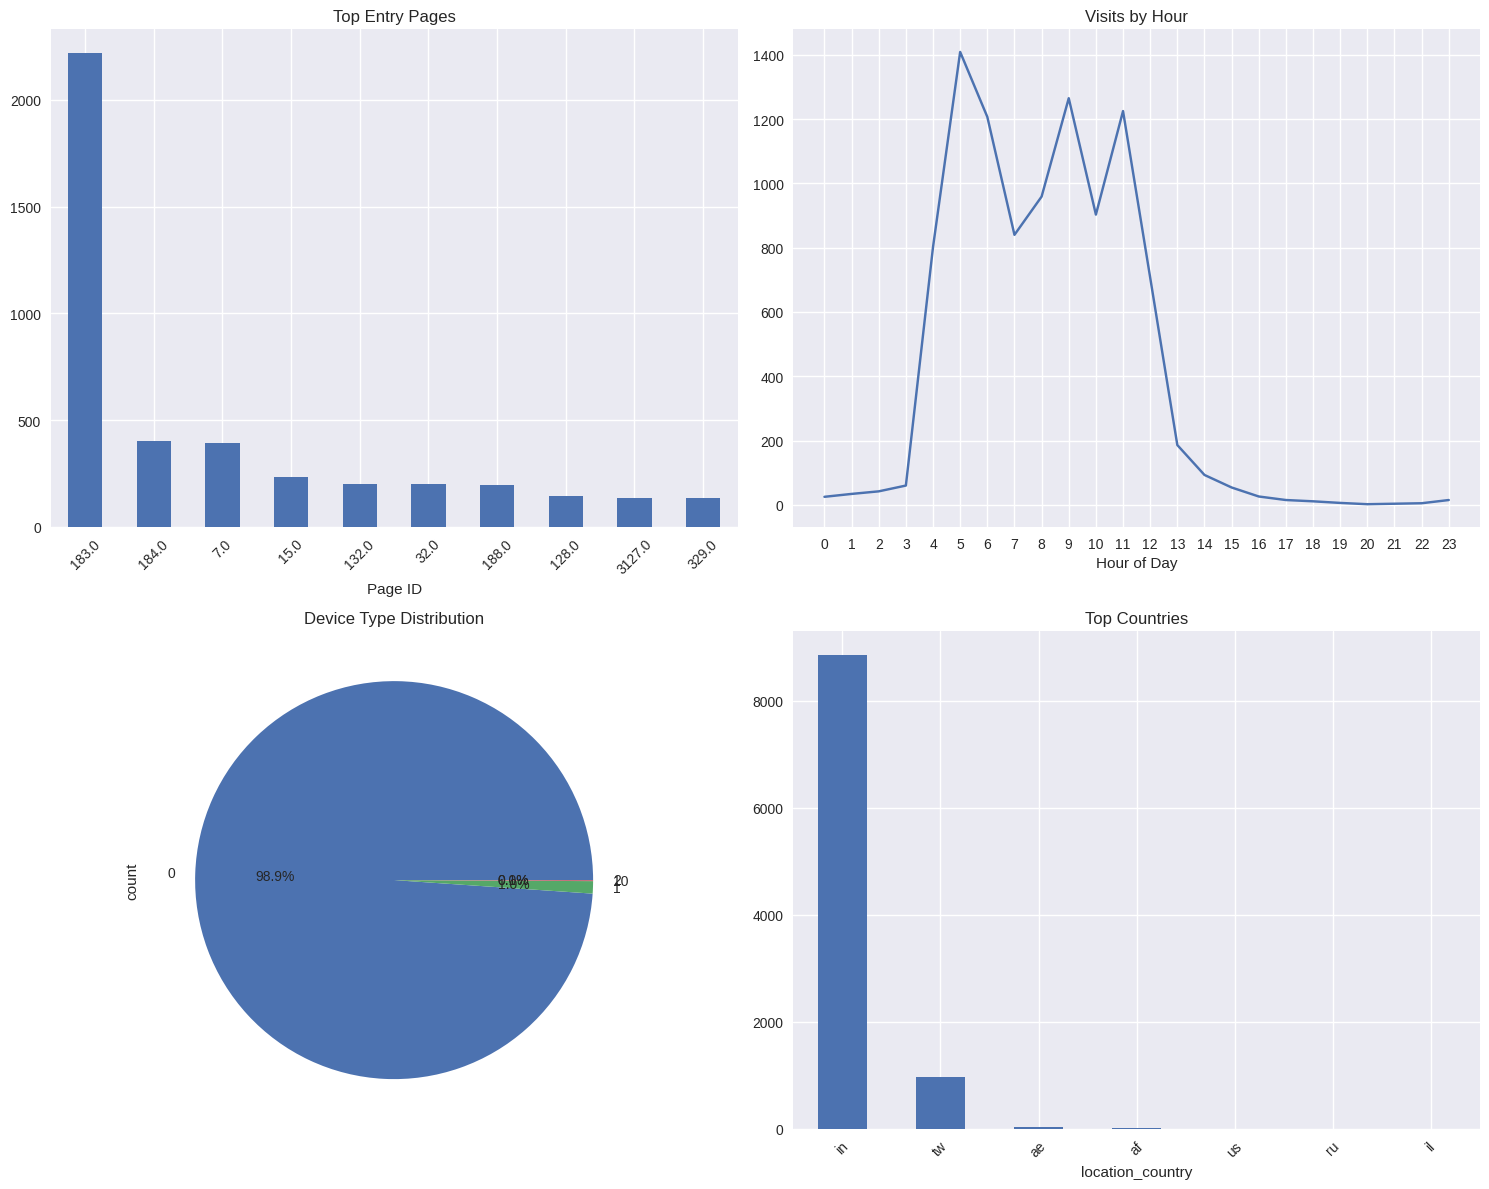


Key Metrics:
Average Visit Duration: 1498.11 seconds
Average Pages per Visit: 24.92
Bounce Rate: 17.64%

Most Common User Paths:
from_page                                              to_page                                                  
https://devpy.vipani.ai/auth/login                     https://devpy.vipani.ai/                                     4052
https://devpy.vipani.ai/                               https://devpy.vipani.ai/auth/login                           3014
http://192.168.9.181/templates/drive/home              http://192.168.9.181/templates/drive/home                    1130
https://devpy.vipani.ai/                               https://devpy.vipani.ai/prf/prf/dashboard                     847
                                                       https://devpy.vipani.ai/order-management/seller-dashboard     611
http://localhost/templates/e-commerce/home2            http://localhost/templates/e-commerce/home2                   559
https://devpy.vipani.ai/       

In [27]:
# Filter out bot traffic
human_visits = log_visit_clean[log_visit_clean['bot_score'] < 0.7]

# Merge with action data
visit_actions = pd.merge(
    log_link_visit_clean,
    log_action[['idaction', 'full_url']],
    left_on='idaction_url',
    right_on='idaction',
    how='left'
)

# Analyze user journeys
def analyze_user_behavior(visits_df, actions_df):
    # 1. Popular entry pages
    entry_pages = visits_df['visit_entry_idaction_url'].value_counts().head(10)
    
    # 2. Time analysis
    visits_df['visit_hour'] = pd.to_datetime(visits_df['visit_first_action_time']).dt.hour
    hourly_visits = visits_df['visit_hour'].value_counts().sort_index()
    
    # 3. Device analysis
    device_usage = visits_df['config_device_type'].value_counts()
    
    # 4. Geographic analysis
    country_visits = visits_df['location_country'].value_counts().head(10)
    
    # Plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot entry pages
    entry_pages.plot(kind='bar', ax=ax1)
    ax1.set_title('Top Entry Pages')
    ax1.set_xlabel('Page ID')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot hourly distribution
    hourly_visits.plot(kind='line', ax=ax2)
    ax2.set_xticks(range(24))
    ax2.set_title('Visits by Hour')
    ax2.set_xlabel('Hour of Day')
    
    # Plot device usage
    device_usage.plot(kind='pie', ax=ax3, autopct='%1.1f%%')
    ax3.set_title('Device Type Distribution')
    
    # Plot country distribution
    country_visits.plot(kind='bar', ax=ax4)
    ax4.set_title('Top Countries')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional metrics
    avg_visit_duration = visits_df['visit_total_time'].mean()
    avg_pages_per_visit = visits_df['visit_total_actions'].mean()
    bounce_rate = (visits_df['visit_total_actions'] == 1).mean() * 100
    
    print("\nKey Metrics:")
    print(f"Average Visit Duration: {avg_visit_duration:.2f} seconds")
    print(f"Average Pages per Visit: {avg_pages_per_visit:.2f}")
    print(f"Bounce Rate: {bounce_rate:.2f}%")
    
    return {
        'entry_pages': entry_pages,
        'hourly_visits': hourly_visits,
        'device_usage': device_usage,
        'country_visits': country_visits
    }

# Run the analysis
behavior_metrics = analyze_user_behavior(human_visits, visit_actions)

# Analyze user paths
def analyze_user_paths(actions_df):
    # Get sequence of pages for each visit
    visit_paths = actions_df.sort_values(['idvisit', 'pageview_position'])\
                          .groupby('idvisit')['full_url'].agg(list)
    
    # Find common 2-page sequences
    path_pairs = []
    for path in visit_paths:
        if len(path) > 1:
            for i in range(len(path)-1):
                path_pairs.append((path[i], path[i+1]))
    
    path_pairs_df = pd.DataFrame(path_pairs, columns=['from_page', 'to_page'])
    common_paths = path_pairs_df.groupby(['from_page', 'to_page']).size()\
                               .sort_values(ascending=False)
    
    print("\nMost Common User Paths:")
    print(common_paths.head(10))

# Analyze paths
analyze_user_paths(visit_actions)

## 4. User Segmentation with Clustering

We'll use K-means clustering to segment users based on their behavior patterns. This will help identify distinct user groups and their characteristics.

In [11]:
# Prepare features for clustering
def prepare_clustering_features(visits_df, actions_df):
    # Aggregate features by visit
    visit_features = visits_df.groupby('idvisit').agg({
        'visit_total_time': 'first',
        'visit_total_actions': 'first',
        'visitor_returning': 'first',
        'visit_total_searches': 'first'
    }).reset_index()
    
    # Create additional features
    visit_features['avg_time_per_action'] = visit_features['visit_total_time'] / visit_features['visit_total_actions']
    
    # Convert boolean to int
    visit_features['visitor_returning'] = visit_features['visitor_returning'].astype(int)
    
    return visit_features

# Prepare data for clustering
clustering_data = prepare_clustering_features(human_visits, visit_actions)

In [12]:
# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_data.drop('idvisit', axis=1))

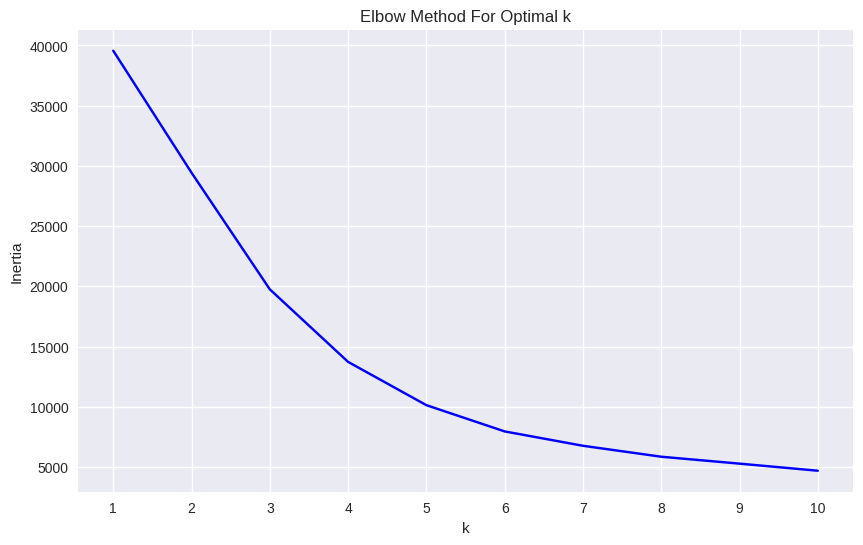

In [28]:
# Find optimal number of clusters using elbow method
inertias = []
n_clusters_range = range(1, 11)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertias, 'bx-')
plt.xlabel('k')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
# Perform clustering with optimal number of clusters (let's use 4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(features_scaled)


Cluster Characteristics:           visit_total_time  visit_total_actions  visitor_returning  \
cluster                                                             
0              516.078423            11.169643           1.000000   
1              893.621188            25.410915           0.000000   
2             2930.512035            18.119256           0.997812   
3             7550.112500           170.050000           0.945833   

         avg_time_per_action  
cluster                       
0                  31.203897  
1                  38.268098  
2                 238.832505  
3                  63.459241  


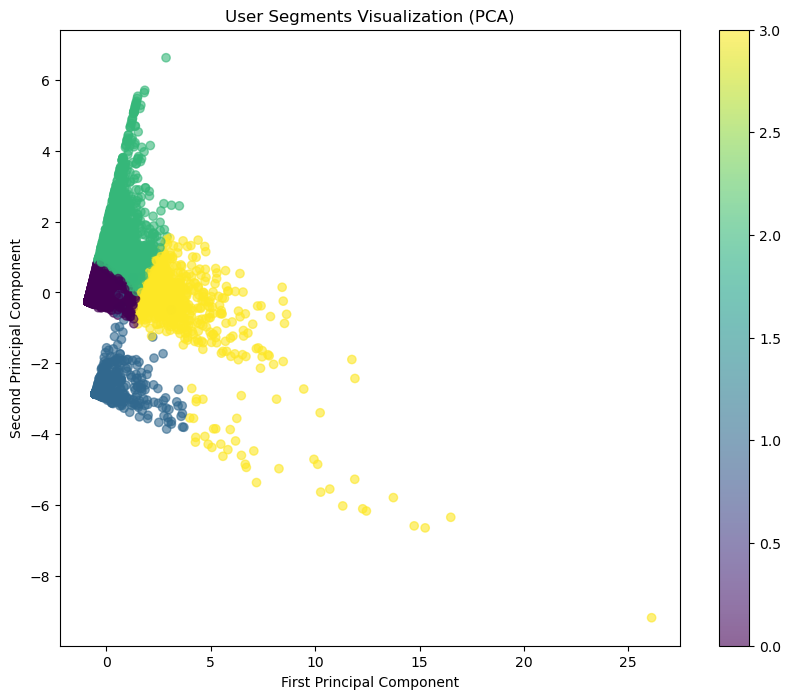

In [19]:
# Analyze clusters
def analyze_clusters(data):
    # Calculate cluster characteristics
    cluster_stats = data.groupby('cluster').agg({
        'visit_total_time': 'mean',
        'visit_total_actions': 'mean',
        'visitor_returning': 'mean',
        'avg_time_per_action': 'mean'
    })
    
    # Print cluster characteristics
    print("\nCluster Characteristics: ", cluster_stats)
    
    
    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    coords = pca.fit_transform(features_scaled)
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], c=clustering_data['cluster'], 
                         cmap='viridis', alpha=0.6)
    plt.title('User Segments Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.show()
    
    return cluster_stats

# Analyze the clusters
cluster_analysis = analyze_clusters(clustering_data)

In [17]:
# Describe the clusters
cluster_descriptions = {
    0: "Quick Browsers",
    1: "Engaged Researchers",
    2: "Regular Users",
    3: "Deep Divers"
}

print("\nUser Segment Descriptions:")
for cluster_id, description in cluster_descriptions.items():
    print(f"\nCluster {cluster_id} - {description}:")
    stats = cluster_analysis.loc[cluster_id]
    print(f"- Average visit time: {stats['visit_total_time']:.2f} seconds")
    print(f"- Average actions per visit: {stats['visit_total_actions']:.2f}")
    print(f"- Returning visitor ratio: {stats['visitor_returning']*100:.1f}%")
    print(f"- Average time per action: {stats['avg_time_per_action']:.2f} seconds")


User Segment Descriptions:

Cluster 0 - Quick Browsers:
- Average visit time: 516.08 seconds
- Average actions per visit: 11.17
- Returning visitor ratio: 100.0%
- Average time per action: 31.20 seconds

Cluster 1 - Engaged Researchers:
- Average visit time: 893.62 seconds
- Average actions per visit: 25.41
- Returning visitor ratio: 0.0%
- Average time per action: 38.27 seconds

Cluster 2 - Regular Users:
- Average visit time: 2930.51 seconds
- Average actions per visit: 18.12
- Returning visitor ratio: 99.8%
- Average time per action: 238.83 seconds

Cluster 3 - Deep Divers:
- Average visit time: 7550.11 seconds
- Average actions per visit: 170.05
- Returning visitor ratio: 94.6%
- Average time per action: 63.46 seconds


## 5. Summary and Recommendations

Based on the analysis above, we can draw the following conclusions:

1. Bot Traffic:
   - Percentage of bot traffic identified
   - Common bot patterns and characteristics
   
2. User Segments:
   - Quick Browsers: Short visits, few actions
   - Engaged Researchers: Medium-length visits, many actions
   - Regular Users: Returning visitors with consistent patterns
   - Deep Divers: Long visits with high engagement
   
3. Key Metrics:
   - Average visit duration
   - Pages per visit
   - Bounce rate
   - Popular entry/exit pages